## Coping with Nonlinearity

In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.preprocessing import PolynomialFeatures
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.models import Sequential

### Linearizing Data Transformations

- Suppose you want to analyze the spread of COVID-19 in Ontraio over the last month.

- You plot the number of confirmed cases against time. The graph is not linear.

- Simple mathematical models suggest that the number of infected increases exponentially in the early stages of an epidemic.
Equivalently, the **logarithm** of the number of infected increases linearly is these stages.

$$
 y = ae^{bx} \Longleftrightarrow \log y = \log a + bx
$$


- Our data seems to agree.

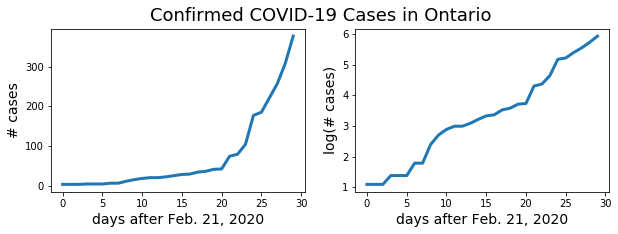

In [3]:
df = pd.read_csv("covid19ontario.csv")
y = df["Cases"].values

fig, [a0, a1] = plt.subplots(1, 2, figsize=(10, 3))
plt.suptitle("Confirmed COVID-19 Cases in Ontario", fontsize=18)
a0.plot(y, lw=3)
a0.set_xlabel("days after Feb. 21, 2020", fontsize=14)
a0.set_ylabel("# cases", fontsize=14)
a1.plot(np.log(y), lw=3)
a1.set_xlabel("days after Feb. 21, 2020", fontsize=14)
a1.set_ylabel("log(# cases)", fontsize=14);

M = LinearRegression()
M.fit(np.arange(len(y)).reshape(-1, 1), y)
loga = M.intercept_
b = M.coef_.item()

- This is an instance of an effective strategy for coping with nonlinearity: apply a **linearizing data transformation**.

- We fit a simple linear regression model to the transformed data.

- Applying the inverse transformation to the regression line gives an exponential fit to the original data set.

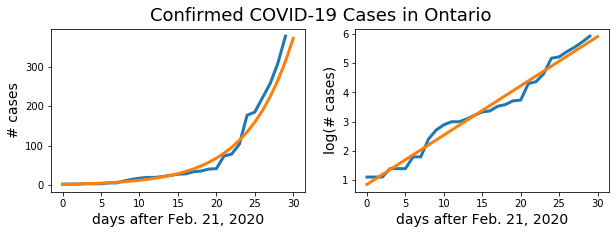

In [4]:
fig, [a0, a1] = plt.subplots(1, 2, figsize=(10, 3))
plt.suptitle("Confirmed COVID-19 Cases in Ontario", fontsize=18)
a0.plot(y, lw=3)
a0.set_xlabel("days after Feb. 21, 2020", fontsize=14)
a0.set_ylabel("# cases", fontsize=14)
a1.plot(np.log(y), lw=3)
a1.set_xlabel("days after Feb. 21, 2020", fontsize=14)
a1.set_ylabel("log(# cases)", fontsize=14);

M = LinearRegression()
M.fit(np.arange(len(y)).reshape(-1, 1), np.log(y))
loga = M.intercept_
a = np.exp(loga)
b = M.coef_.item()
a1.plot([0, 30], [loga + b*0, loga + b*30], lw=3)
x = np.arange(31)
a0.plot(x, a*np.exp(b*x), lw=3);

Source: [humdata.org](https://data.humdata.org/dataset/novel-coronavirus-2019-ncov-cases)

## Feature Engineering

We want to train a classifier on the following synthetic data set in which colors indicate class labels.

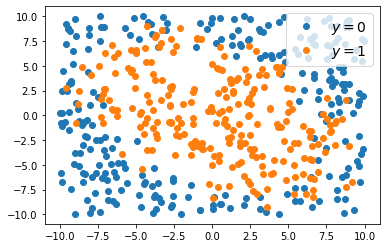

In [5]:
X = 20*np.random.uniform(size=(500, 2)) - 10
y = 1*((X[:,0] - X[:,1])**2/14**2 + (X[:,0] + X[:,1])**2/81 + np.random.normal(0, 0.3, size=500) < 1)
plt.plot(*X[y==0, :].T, 'o', label="$y=0$")
plt.plot(*X[y==1, :].T, 'o', label="$y=1$")
plt.legend(fontsize=14, loc="upper right");

- The data don't appear to be **linearly inseparable**, so logistic regression, linear discriminants, and similar methods aren't appropriate for this classification task.

- It looks like the classes can be separated by an **ellipse**, and these are described by **nonlinear** equations in **two** variables of the form
$$
a + bx_0 + cx_1 + dx_0^2 + ex_0x_1 + fx_1^2 = 0.
\tag{$*$}
$$

- However, if we introduce new features,
$$
x_2 = x_0^2,\qquad x_3 = x_0x_1,\qquad x_4 = x_1**2,
$$
then $(*)$ becomes a **linear** equation **five** variables:
$$
a + bx_0 + cx_1 + dx_2 + ex_3 + fx_4 = 0.
$$

- Thus, the expanded data set $\{(x_0,x_1,x_2,x_3,x_4)\}$ **is** linearly separable and the resulting classification problem yields to logistic regression.

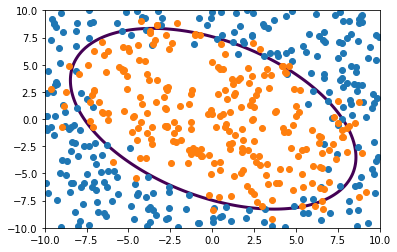

In [6]:
P = PolynomialFeatures(degree=2, include_bias=False)
XX = P.fit_transform(X)
M = LogisticRegression(solver="lbfgs")
M.fit(XX, y)

t = np.linspace(-10, 10, 100)
U, V = np.meshgrid(t, t)
UV = np.stack([U.reshape(-1), V.reshape(-1)], axis=1)
W = (P.fit_transform(UV).dot(M.coef_.T) + M.intercept_).reshape(U.shape)
plt.plot(*X[y==0, :].T, 'o')
plt.plot(*X[y==1, :].T, 'o')
plt.contour(U, V, W, levels=[0], linewidths=[3]);

What are our options if we don't know how to linearize the data, either through data transformation or through feature engineering?

1. Use a standard set of features (e.g., monomials) to extend your data set, likely in combination with trial-and-error.

2. Use a nonparametric method.

3. Use **deep learning**: Learn features and perform regression **simultaneously**.

## Deep Learning

<!-- Training a linear regression model:

$$
\text{minimize over }\beta,\vec{\beta}: \qquad \frac1n\sum_{i=1}^1 (\beta_0 + \vec{x}_i\cdot\vec{\beta} - y_i)^2
$$

Training a linear regression model with data transformation $\vec F$:

$$
\text{minimize over }\beta_0,\vec{\beta}: \qquad \frac1n\sum_{i=1}^1 (\beta_0 + \vec F(\vec{x}_i)\cdot\vec{\beta} - y_i)^2
$$

Training a deep regression model with parametric family data transformations $\vec F(\vec x|\vec{\alpha})$:

$$
\text{minimize over }\beta_0,\vec{\beta},\vec \alpha: \qquad
\frac1n\sum_{i=1}^1 (\beta_0 + \vec F(\vec{x}_i| \vec{\alpha}) \cdot\vec{\beta} - y_i)^2
$$
 -->
Training a general deep learning model, $\vec F(\vec x|\vec \theta)$:

$$
\text{minimize over }\theta: \qquad
\frac1n\sum_{i=1}^1 \operatorname{Loss}\big( F(x_i| \theta),\, y_i\big)
$$

#### Examples:
Linear regression:
$$F(x|\beta)=\beta_0 + x\cdot \beta,\qquad\text{and}\qquad \operatorname{Loss}=\operatorname{MSE}$$

Logistic regression:
$$F(x|\beta)=\beta_0 + x\cdot \beta,\qquad\text{and}\qquad \operatorname{Loss}=\text{binary cross-entropy}$$


Deep regression:
$$
\theta=(\alpha,\beta),\qquad
F(x|\theta)=\beta_0 + T(x|\alpha)\cdot \beta,\qquad\text{and}\qquad \operatorname{Loss}=\operatorname{MSE}
$$

Deep binary classification:
$$
\theta=(\alpha,\beta),\qquad
F(x|\theta)=\beta_0 + T(x|\alpha)\cdot \beta,\qquad\text{and}\qquad \operatorname{Loss}=\text{binary cross-entropy}
$$



### Deep Binary Classification

Learn a transformation $T$ such that logistic regression "works" for the transformed data set $(T(X), y)$.

Consider $T$ belonging to a parametric family $T(x|\alpha)$ and

$$
\text{minimize over }\alpha, \beta:\qquad \frac1n\sum_{i=1}^n\left\{y_i\log \hat y_i + (1-y_i)\log\big(1-\hat y_i\big)\right\},
$$
where
$$\hat{y}_i=\sigma(\beta_0 + \beta_1\cdot T(x_i|\alpha))$$
and $\sigma(x)$ is the **sigmoid function**:
$$
\sigma(x)=\frac1{1+e^{-x}}
$$

Typically, $T(x|\alpha)$ is a **neural network**.

#### Example:

We want to train a classifier on the following synthetic data set in which colors indicate class labels.

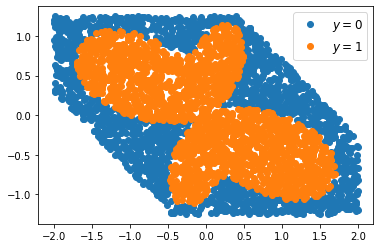

In [7]:
n = 5000
X0 = 4*np.random.uniform(size=(n,1)) - 2
X1 = 2.5*np.random.uniform(size=(n, 1)) - 1.25
X = np.concatenate([X0, X1], axis=1).astype(np.float32)
I = (np.abs(X[:,0] + X[:,1])) < 1.7
X = X[I, :]
R = np.linalg.norm(X, axis=1)
Q = np.arctan2(X[:,1], X[:,0])
y = 1*(R < 1 - np.cos(Q)*np.sin(3*Q))
plt.plot(*X[y==0, :].T, 'o', label="$y=0$")
plt.plot(*X[y==1, :].T, 'o', label="$y=1$")

q = np.linspace(0, 2*np.pi, 1000)
r = 1 - np.cos(q)*np.sin(3*q)
# plt.plot(r*np.cos(q), r*np.sin(q), 'k', lw=5)
# plt.plot(r*np.cos(q), r*np.sin(q), 'r', lw=3)
plt.legend(fontsize=12, loc="upper right");

We **simultaneously** train a neural network to learn a 200-dimensional representation of our 2-dimensional data set and a logistic regression model to classify points based on this representation.

In [30]:
T = Dense(200, input_shape=(2,), activation="relu")
model = Sequential([Input(2), T, Dense(1, activation="sigmoid")])
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_8 (Dense)              (None, 200)               600       
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 201       
Total params: 801
Trainable params: 801
Non-trainable params: 0
_________________________________________________________________


In [32]:
model.fit(X, y, epochs=500)

Train on 3790 samples
Epoch 1/500
3790/3790 [==============================] - 0s 101us/sample - loss: 0.6609 - accuracy: 0.6214
Epoch 2/500
3790/3790 [==============================] - 0s 24us/sample - loss: 0.6018 - accuracy: 0.7317
Epoch 3/500
3790/3790 [==============================] - 0s 25us/sample - loss: 0.5354 - accuracy: 0.8084
Epoch 4/500
3790/3790 [==============================] - 0s 24us/sample - loss: 0.4801 - accuracy: 0.8251
Epoch 5/500
3790/3790 [==============================] - 0s 25us/sample - loss: 0.4437 - accuracy: 0.8343
Epoch 6/500
3790/3790 [==============================] - 0s 25us/sample - loss: 0.4213 - accuracy: 0.8296
Epoch 7/500
3790/3790 [==============================] - 0s 25us/sample - loss: 0.4060 - accuracy: 0.8380
Epoch 8/500
3790/3790 [==============================] - 0s 25us/sample - loss: 0.3960 - accuracy: 0.8367
Epoch 9/500
3790/3790 [==============================] - 0s 25us/sample - loss: 0.3862 - accuracy: 0.8456
Epoch 10/500
3790/3790 

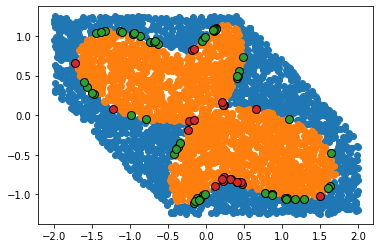

In [33]:
y_pr = model.predict_classes(X).squeeze()
plt.plot(*X[y_pr==0, :].T, 'o', label="$y=0$")
plt.plot(*X[y_pr==1, :].T, 'o', label="$y=1$")
plt.plot(*X[np.logical_and(y_pr==0, y==1), :].T, 'o', mec='k', ms=8)
plt.plot(*X[np.logical_and(y_pr==1, y==0), :].T, 'o', mec='k', ms=8);

Let's use a **deeper** network to learn a linearly separable, 2-dimensional representation of our data set.

In [55]:
d = 200
model = Sequential([Input(2), Dense(d, activation="relu"), Dense(2, activation="relu"), Dense(1, activation="sigmoid")])
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_13 (Dense)             (None, 200)               600       
_________________________________________________________________
dense_14 (Dense)             (None, 2)                 402       
_________________________________________________________________
dense_15 (Dense)             (None, 1)                 3         
Total params: 1,005
Trainable params: 1,005
Non-trainable params: 0
_________________________________________________________________


In [34]:
model.fit(X, y, epochs=500)

Train on 3790 samples
Epoch 1/500
3790/3790 [==============================] - 1s 142us/sample - loss: 0.6618 - accuracy: 0.5971
Epoch 2/500
3790/3790 [==============================] - 0s 26us/sample - loss: 0.5650 - accuracy: 0.7649
Epoch 3/500
3790/3790 [==============================] - 0s 26us/sample - loss: 0.4685 - accuracy: 0.8235
Epoch 4/500
3790/3790 [==============================] - 0s 25us/sample - loss: 0.4105 - accuracy: 0.8409
Epoch 5/500
3790/3790 [==============================] - 0s 25us/sample - loss: 0.3824 - accuracy: 0.8393
Epoch 6/500
3790/3790 [==============================] - 0s 26us/sample - loss: 0.3626 - accuracy: 0.8449
Epoch 7/500
3790/3790 [==============================] - 0s 26us/sample - loss: 0.3497 - accuracy: 0.8528
Epoch 8/500
3790/3790 [==============================] - 0s 26us/sample - loss: 0.3356 - accuracy: 0.8567
Epoch 9/500
3790/3790 [==============================] - 0s 25us/sample - loss: 0.3193 - accuracy: 0.8636
Epoch 10/500
3790/3790 

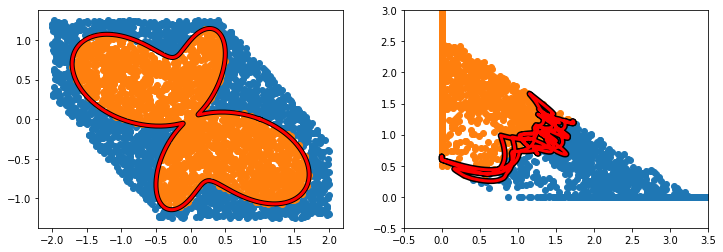

In [54]:
[L0, L1, L2] = model.layers
Z = L1(L0(X)).numpy()
qr = np.stack([r*np.cos(q), r*np.sin(q)], axis=1)
S = L1(L0(qr)).numpy()

fig, [a0, a1] = plt.subplots(1, 2, figsize=(12, 4))

y_pr = model.predict_classes(X).squeeze()
a0.plot(*X[y_pr==0, :].T, 'o', label="$y=0$")
a0.plot(*X[y_pr==1, :].T, 'o', label="$y=1$")
q = np.linspace(0, 2*np.pi, 1000)
r = 1 - np.cos(q)*np.sin(3*q)
a0.plot(r*np.cos(q), r*np.sin(q), 'k', lw=5)
a0.plot(r*np.cos(q), r*np.sin(q), 'r', lw=3)
# plt.plot(*X[np.logical_and(y_pr==0, y==1), :].T, 'o', mec='k', ms=8)
# plt.plot(*X[np.logical_and(y_pr==1, y==0), :].T, 'o', mec='k', ms=8);

a1.plot(*Z[y==0, :].T, 'o')
a1.plot(*Z[y==1, :].T, 'o')
a1.plot(*S.T, 'k', lw=6)
a1.plot(*S.T, 'r', lw=3)
a1.set_xlim(-0.5, 3.5)
a1.set_ylim(-0.5, 3);

### Questions

1. What is a neural network?

2. How do you construct a neural network?

3. How to you train a neural network?